In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import MetaTrader5 as mt5
from account_credentials import LOGIN,PASSWORD,SERVER
from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [2]:
is_initialized = mt5.initialize()
print('initialize: ', is_initialized)

is_logged_in = mt5.login(LOGIN, PASSWORD, SERVER)
print('logged in: ', is_logged_in)
print('\n')
account_info = mt5.account_info()
print(datetime.now(),
    '| Login: ', account_info.login,
    '| Balance: ', account_info.balance,
    '| Equity: ' , account_info.equity)

initialize:  True
logged in:  True


2023-04-25 07:08:33.110800 | Login:  114123121 | Balance:  484.96 | Equity:  484.96


In [3]:
symbol = 'XAUUSD'
number_of_date= 10000
timeframe = mt5.TIMEFRAME_H1
from_date = datetime.now()

df = pd.DataFrame(mt5.copy_rates_from(symbol,timeframe,from_date,number_of_date))
df["time"] = pd.to_datetime(df["time"], unit="s")
df = df.rename(columns={'time': 'date','tick_volume':'volume'})
df = df[['date','open','high','low','close','volume']]
df = df.set_index("date")
print(df.head()) # just to make sure that sorted from old to new

                         open      high       low     close  volume
date                                                               
2021-08-13 09:00:00  1756.065  1759.093  1755.970  1758.467    2585
2021-08-13 10:00:00  1758.465  1761.730  1758.397  1759.760    2892
2021-08-13 11:00:00  1759.791  1761.151  1758.416  1759.252    3297
2021-08-13 12:00:00  1759.283  1763.129  1757.027  1762.845    5243
2021-08-13 13:00:00  1762.883  1765.735  1762.298  1764.944    6751


##### Adding Features

In [4]:
df['RSI'] = ta.rsi(df.close, length = 15)
df['EMAF'] = ta.ema(df.close, length = 20)
df['EMAM'] = ta.ema(df.close, length = 100)
df['EMAS'] = ta.ema(df.close, length = 150)
# df['Target'] = df['close'] - df.open
# df['Target'] = df['Target'].shift(-1)

# df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]
df['Target-Next-Close'] = df['close'].shift(-1)



df.dropna(inplace = True)
df.reset_index(inplace = True)
df.drop(['date','volume'], axis=1 , inplace=True)
# df = df[0:100]
df

,open,high,low,close,RSI,EMAF,EMAM,EMAS,Target-Next-Close
0,1804.986,1805.199,1803.067,1803.721,72.659533,1795.720783,1786.645507,1784.345540,1805.396
1,1803.767,1805.490,1803.485,1805.396,74.477918,1796.642232,1787.016804,1784.624354,1804.849
2,1804.979,1805.908,1804.833,1804.849,72.784155,1797.423829,1787.369916,1784.892230,1804.815
3,1804.845,1805.802,1804.724,1804.815,72.674088,1798.127750,1787.715364,1785.156108,1801.992
4,1804.768,1805.024,1801.943,1801.992,64.056583,1798.495774,1787.998069,1785.379100,1804.108
...,...,...,...,...,...,...,...,...,...
9845,1989.543,1990.342,1987.943,1989.780,57.976620,1984.415135,1992.116196,1995.195659,1988.748
9846,1989.749,1989.860,1987.511,1988.748,56.068765,1984.827789,1992.049499,1995.110260,1989.123
9847,1988.717,1989.474,1988.303,1989.123,56.624480,1985.236857,1991.991549,1995.030959,1992.646
9848,1989.059,1993.508,1988.842,1992.646,61.523595,1985.942490,1992.004508,1994.999370,1995.053


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler_x = StandardScaler().fit(df.iloc[:,:8])
scaled_x = scaler_x.transform(df.iloc[:,:8])
scaler_y = StandardScaler().fit(df.iloc[:,8].values.reshape(-1, 1))
scaled_y = scaler_y.transform(df.iloc[:,8].values.reshape(-1, 1))
scaled_x.shape

In [5]:
scaler_x = MinMaxScaler(feature_range=(0,1))
scaled_x = scaler_x.fit_transform(df.iloc[:,:8])
print(scaled_x.shape)
scaled_x

(9850, 8)


array([[0.41584169, 0.41076004, 0.43149084, ..., 0.41085628, 0.38665195,
        0.38089224],
       [0.41314981, 0.41140668, 0.43244784, ..., 0.41308423, 0.38762595,
        0.38164428],
       [0.41582624, 0.41233553, 0.43553405, ..., 0.41497404, 0.38855224,
        0.38236683],
       ...,
       [0.82156951, 0.82024457, 0.85558438, ..., 0.86908359, 0.92532113,
        0.94917533],
       [0.82232474, 0.82920867, 0.85681841, ..., 0.87078973, 0.92535512,
        0.94909012],
       [0.83024801, 0.83593064, 0.86331594, ..., 0.87288765, 0.92551348,
        0.94909204]])

In [6]:
scaler_y = MinMaxScaler(feature_range=(0,1))
scaled_y = scaler_y.fit_transform(df.iloc[:,8].values.reshape(-1, 1))
print(scaled_y.shape)
scaled_y

(9850, 1)


array([[0.41676531],
       [0.41555728],
       [0.4154822 ],
       ...,
       [0.83029964],
       [0.83561541],
       [0.83500146]])

In [7]:
# # Save the array to a CSV file
# np.savetxt('arrayx.csv', scaled_x, delimiter=',')
# np.savetxt('arrayy.csv', scaled_y, delimiter=',')

In [8]:
X = []
backcandles = 30
print(scaled_x.shape[0])
for j in range(8): 
    X.append([])
    for i in range(0, scaled_x.shape[0]-backcandles+1):
        X[j].append(scaled_x[i:i+backcandles, j])
print(np.array(X).shape)

X = np.moveaxis(X, [0], [2])  # move the feature axis to the second dimension
print(X.shape)

9850
(8, 9821, 30)
(9821, 30, 8)


In [9]:
# X = []
# backcandles = 30
# print(df_a.shape[0])
# for j in range(8): # grabe open	high	low	close	RSI	EMAF	EMAM	EMAS
#     X.append([])
#     for i in range(backcandles, df_a.shape[0]):
#         X[j].append(df_a[i-backcandles:i, j])
# X=np.moveaxis(X, [0], [2])
# X.shape


# X = []
# backcandles = 30
# print(scaled_x.shape[0])
# for j in range(8): 
#     X.append([])
#     for i in range(backcandles, scaled_x.shape[0]):
#         X[j].append(scaled_x[i-backcandles:i, j])
# X = np.moveaxis(X, [0], [2])  # move the feature axis to the second dimension
# X = X[::-1]  # reverse the order of the samples to put the most recent data at the end
# X.shape


In [10]:
X[0,0,:]

array([0.41584169, 0.41076004, 0.43149084, 0.41306614, 0.75224949,
       0.41085628, 0.38665195, 0.38089224])

In [11]:
X[0,1,:]

array([0.41314981, 0.41140668, 0.43244784, 0.41676531, 0.77445318,
       0.41308423, 0.38762595, 0.38164428])

In [12]:
# X = X
y = scaled_y[(scaled_y.shape[0]-X.shape[0]):,:] # matching the shape of X
# y = np.reshape(y,(len(y),1))
print(X.shape) # 3D X has 8 colume and each colume contain xx backcandles (row, backcandle, column)
print(y.shape) # 2D contain 1 value (it's 1D array that reshape into 2D array)
print(y)

(9821, 30, 8)
(9821, 1)
[[0.39347709]
 [0.39201288]
 [0.39386799]
 ...
 [0.83029964]
 [0.83561541]
 [0.83500146]]


In [13]:
proportion = int(len(X)*0.8)
X_train, X_test = X[:proportion],X[proportion:]
y_train, y_test = y[:proportion],y[proportion:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X[1,1:10,1])

(7856, 30, 8)
(7856, 1)
(1965, 30, 8)
(1965, 1)
[0.41233553 0.41209999 0.41037116 0.40955342 0.40935342 0.40572467
 0.40355364 0.4080557  0.41046672]


In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the Sequential model
model = Sequential()

# Add the LSTM layer with 150 units and input shape (backcandles, 8)
model.add(LSTM(units=150, input_shape=(backcandles, 8), name='lstm_layer'))

# Add a dense layer with a single output neuron and linear activation function
model.add(Dense(units=1, activation='linear', name='output'))

# Compile the model with the Adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mse')

# Train the model on the training data with a batch size of 15 and for 30 epochs
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_data=(X_test, y_test))


Epoch 1/30
524/524 [==============================] - 5s 8ms/step - loss: 9.3934e-04 - val_loss: 1.5837e-04
Epoch 2/30
524/524 [==============================] - 4s 8ms/step - loss: 1.1788e-04 - val_loss: 1.0982e-04
Epoch 3/30
524/524 [==============================] - 4s 8ms/step - loss: 9.9106e-05 - val_loss: 1.0085e-04
Epoch 4/30
524/524 [==============================] - 4s 8ms/step - loss: 9.8389e-05 - val_loss: 8.5936e-05
Epoch 5/30
524/524 [==============================] - 4s 8ms/step - loss: 9.5547e-05 - val_loss: 8.3758e-05
Epoch 6/30
524/524 [==============================] - 4s 8ms/step - loss: 9.6968e-05 - val_loss: 2.1967e-04
Epoch 7/30
524/524 [==============================] - 4s 8ms/step - loss: 9.6478e-05 - val_loss: 1.5096e-04
Epoch 8/30
524/524 [==============================] - 4s 8ms/step - loss: 9.1617e-05 - val_loss: 7.8139e-05
Epoch 9/30
524/524 [==============================] - 4s 8ms/step - loss: 1.0132e-04 - val_loss: 1.5887e-04
Epoch 10/30
524/524 [=======

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer (LSTM)           (None, 150)               95400     
                                                                 
 output (Dense)              (None, 1)                 151       
                                                                 
Total params: 95,551
Trainable params: 95,551
Non-trainable params: 0
_________________________________________________________________


In [16]:
y_hat = model.predict(X_test)
for i in range(10):
    print(y_hat[i], y_test[i])

62/62 [==============================] - 0s 4ms/step
[0.44131613] [0.43965822]
[0.44108102] [0.43405314]
[0.4348736] [0.43384555]
[0.43548492] [0.43513529]
[0.43610758] [0.43966043]
[0.44110525] [0.44376154]
[0.4467828] [0.44638961]
[0.44836092] [0.44420323]
[0.4486265] [0.44121077]
[0.44220084] [0.44210961]


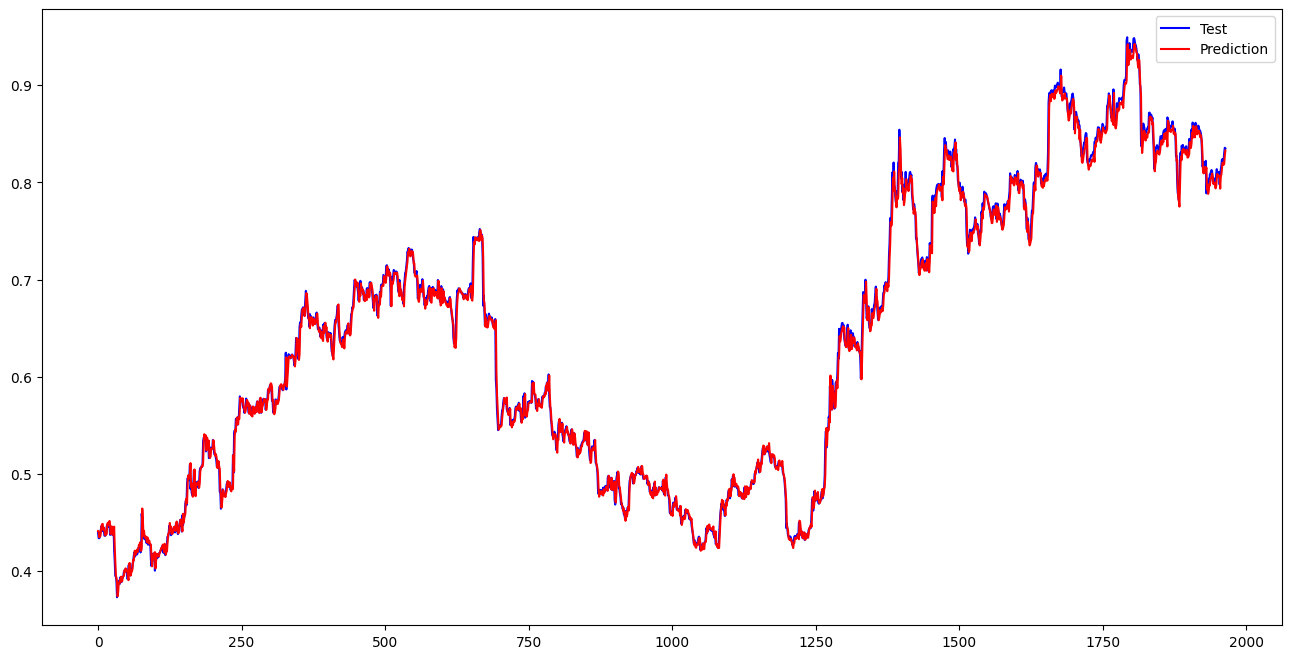

In [17]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_hat, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

In [18]:
y_hat_inverse = scaler_y.inverse_transform(y_hat)
print(y_hat_inverse)
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
print(y_test_inverse)

[[1816.5128]
 [1816.4064]
 [1813.5956]
 ...
 [1987.71  ]
 [1991.3828]
 [1993.7953]]
[[1815.762]
 [1813.224]
 [1813.13 ]
 ...
 [1992.646]
 [1995.053]
 [1994.775]]


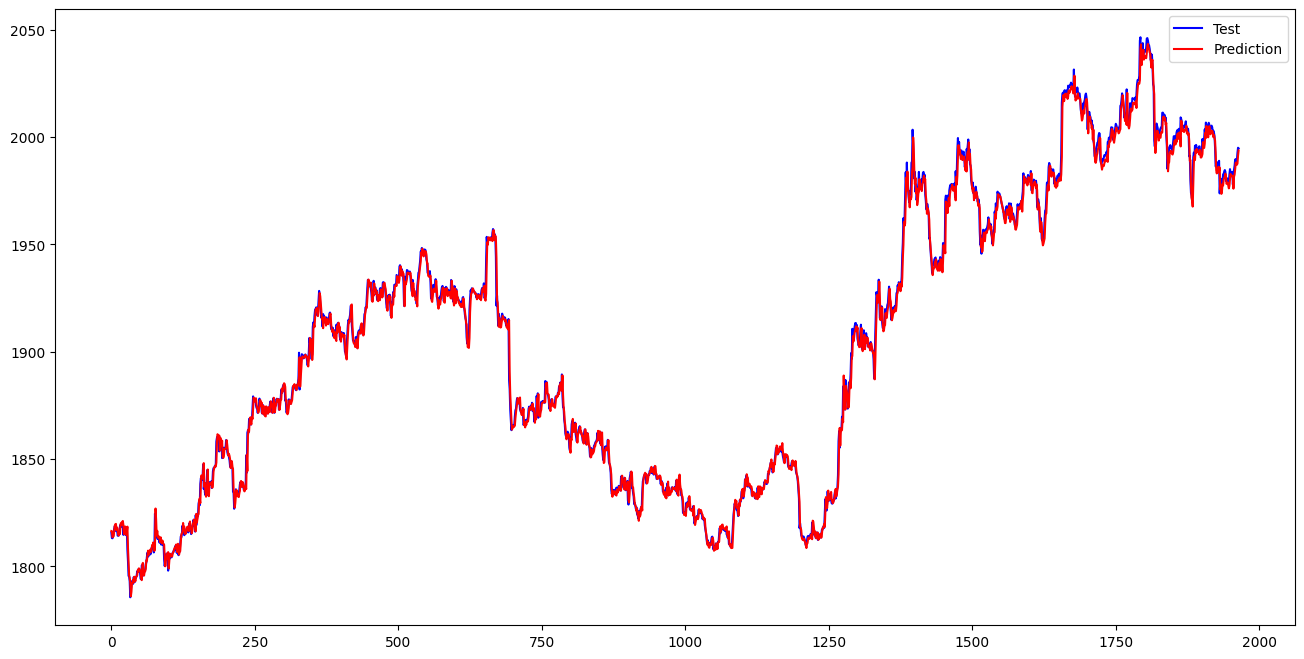

In [20]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inverse, color = 'blue', label = 'Test')
plt.plot(y_hat_inverse, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

In [19]:
#อันนี้ถ้าได้ค่าเป็นบวก ก็แค่บอกเป็นความในว่า ใน data ที่ใช้ test นี้ ส่วนไหญ่แล้วมี Tredn ราคาหลักไปทางนั้งมากกว่า เช่น ถ้าเป็น positve แปลว่าส่วนมาก ราคาขึ้น negative ก็แปลว่าส่วนมากราคาลง
diff = []
for i in range(0,len(y_hat_inverse)):
    val = float(y_hat_inverse[i] - y_test_inverse[i])
    diff.append(val)
pred_diff = sum(diff)/len(diff)
print(f"pred_diff {pred_diff}")



#อาจจะเป็น predict long or short ก็ได้ regardless of neg or pos, see below
# Predict < ClosePrice(from predict) > actual ---> Short ---> P - a = Positive Value
# Predict < ClosePrice(from predict) < actual ---> Short ---> P - a = Negative Value
# Predict > ClosePrice(from predict) > actual ---> Long ---> P - a = Positive Value
# Predict > ClosePrice(from predict) < actual ---> Long ---> P - a = Negative Value
# ด้วยเหตุผลนี้ ใช้ เป็น abs น่าจะ make sense มากกว่าในการทำ simulation
diff_pos = []
diff_neg = []
v_zero = []
for i in range(0,len(y_hat_inverse)):
    val = float(y_hat_inverse[i] - y_test_inverse[i])
    if val > 0:
        diff_pos.append(val)
    elif val < 0:
        diff_neg.append(val)
    elif val ==0:
        v_zero.append(val)
    else:
        raise ValueError("All conditions were not met")
pred_diff_pos = sum(diff_pos)/len(diff_pos)
pred_diff_neg = sum(diff_neg)/len(diff_neg)
print(f"pred_diff_pos {pred_diff_pos}")
print(f"pred_diff_neg {pred_diff_neg}")
print(f"v_zero {v_zero}")

#ใช้อันนี้น่าจะ make sense สุดเพราะ เราไม่สามารถรู้ได้ว่ามันจะ เป็น Negative Diff หรือว่า Positive Diff, regardless what's the type of trading order is.
diff = []
for i in range(0,len(y_hat_inverse)):
    val = abs(float(y_hat_inverse[i] - y_test_inverse[i]))
    diff.append(val)
pred_diff_abs = sum(diff)/len(diff)
print(f"pred_diff_abs {pred_diff_abs}")

pred_diff -0.7838433221016249
pred_diff_pos 2.3678780597322464
pred_diff_neg -2.9299256317164737
v_zero []
pred_diff_abs 2.702246309935587


In [21]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)

# Print the mean squared error loss
print('Test loss:', loss)

# Generate predictions on the test data
y_pred = model.predict(X_test)

# Compute the mean squared error (MSE) and root mean squared error (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Compute the coefficient of determination (R-squared)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print("TEST SET")
print('Mean squared error (MAE)(loss):', mae)
print('Mean squared error (MSE)(loss):', mse)
print('Root mean squared error (RMSE):', rmse)
print('R-squared (R2):', r2)
print()

loss = model.evaluate(X_train, y_train)
print('Training loss:', loss)

y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_train, y_pred)
print("TRAINING SET")
print('Mean squared error (MAE)(loss):', mae)
print('Mean squared error (MSE):', mse)
print('Root mean squared error (RMSE):', rmse)
print('R-squared (R2):', r2)

62/62 [==============================] - 0s 4ms/step - loss: 7.4735e-05
Test loss: 7.473452569684014e-05
62/62 [==============================] - 0s 4ms/step
TEST SET
Mean squared error (MAE)(loss): 0.005967803222583994
Mean squared error (MSE)(loss): 7.473452797454663e-05
Root mean squared error (RMSE): 0.008644913416255054
R-squared (R2): 0.9966457705887249

246/246 [==============================] - 1s 4ms/step - loss: 6.1402e-05
Training loss: 6.14017408224754e-05
246/246 [==============================] - 1s 4ms/step
TRAINING SET
Mean squared error (MAE)(loss): 0.005310558321328632
Mean squared error (MSE): 6.140176161010616e-05
Root mean squared error (RMSE): 0.007835927616441219
R-squared (R2): 0.9980831290654505


In [33]:
#เนื่องจากพอสร้าง ออเด้อแล้วใช้ sl tp เท่ากัน ยังไงก็เสียมากกว่าเนื่องจาก spread
# if win >>> gain x
# if lost >>> loss x + spread

diff = pred_diff_abs
tp_sl_range = 3.1
spread = 200
# for loop
close = 1918
prediction = 1921
actual = 1922


if prediction == 0:
    print("Do nothing")

# LONG
elif prediction > close:
    # must be after prediction >= close
    target_price_l = close + tp_sl_range + spread # เพิ่ม spread เพิ่มเมื่อ win จะได้เอา spread คืน
    # must be after prediction >= close, because we don't know whether to plus or minus prediction with pred_diff
    prediction = prediction - pred_diff
    if prediction <= target_price_l:
        print("Do nothing")
    elif prediction > target_price_l and actual > target_price_l:
        print("trade L win")
    elif prediction > target_price_l and actual < target_price_l:
        print("Trade L loss")
    else:
        print("error")
        print(prediction)


# SHORT
elif prediction < close:
        # must be after prediction >= close
    target_price_s = close - tp_sl_range - spread # เพิ่ม spread เพิ่มเมื่อ win จะได้เอา spread คืน
    # must be after prediction >= close, because we don't know whether to plus or minus prediction with pred_diff
    prediction = prediction + pred_diff
    if prediction >= target_price_s:
        print("Do nothing")
    elif prediction < target_price_s and actual < target_price_s:
        print("trade L win")
    elif prediction < target_price_s and actual > target_price_s:
        print("Trade L loss")
    else:
        print("error")
        print(prediction)

else:
    raise ValueError("Error condition not met")
    

trade L win


In [ ]:
if prediction - close > 3 then buy
if target > 3 then buy is correct
This is correct
else false

if prediction - close < 3 then sell
if target > 3 then sell is correct
This is correct
else false

if prediction - close > 3 AND prediction - close < 3 then doing nothing

# with a single model it cannot predict sell and buy at the sametime

In [ ]:
# float(model.predict(X_test[0, :, :].reshape(1, 30, 8)))
# y_hat = model.predict(X_test)
# float(y_hat[0])
scaled_sample_x = scaler_x.inverse_transform(X_train[0, :, :])
scaled_sample_x[0,4]
# y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
def predict_simu(model, X_test, data_simu_y, initial_capital):
    capital = initial_capital
    win_count = 0
    lost_count = 0
    no_order_count = 0
    record_result = []
    record_capital = []
    record_date = []
    consecutive_lost = 0
    consecutive_lost_max = 0
    diff = pred_diff_abs
    tp = 3.1
    sl = 3.1
    spread = 200
    for i in range(0, len(X_test)):
        prediction = float(model.predict(X_test[0, :, :].reshape(1, 30, 8)))

        if prediction == 1 and data_simu_y[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'win'
        elif prediction == 1 and data_simu_y[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'lost'
        elif prediction == 0:
            no_order_count +=1
            order_record = 'no order--- prediction = {0}, actual = {1}'.format(prediction, data_simu_y[i])
            capital = capital
            result = 'no order'
        else:
            raise ValueError('no condition met')
        record_date.append(X_test.iloc[i].name)
        record_result.append(order_record)
        record_capital.append(capital)

        #Calculate Consecutive Lost
        if result == 'lost':
            consecutive_lost += -3.3
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
        if result == 'win':
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
            consecutive_lost = 0

    total_return = ((capital - initial_capital) / initial_capital)*100
    sim_df = pd.DataFrame({'record_date':record_date,
                           'record_result':record_result,
                           'record_capital': record_capital})
    sim_df.set_index('record_date', inplace=True)

    return win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max
